In [1]:
from src.functions import *

In [2]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
from bayes_opt import UtilityFunction

In [3]:
from joblib import Parallel, delayed

In [4]:
n=8

In [5]:
T=0.5
t_max=10
interpolator_kind='cubic'
n_random_models=200
n_iter=200
init_points=20
kappa=2

In [6]:
file_name = f'n{n}_{interpolator_kind}_BO_TEST'

In [7]:
def loss_ra(x1,x2,x3):
    '''
    Computes the negative average delta for multiple random Ising models 
    using for a given ramp-up schedule and maximum time.
    '''
    ramp_up_schedule = [x1,x2,x3]

    schedule = get_symmetric_schedule(ramp_up_schedule) # mirror and append the ramp up schedule
    schedule_interpolator = get_schedule_interpolator(schedule, kind=interpolator_kind) # get an interpolating function for the continuos schedule
    
    # delta_sum = 0    
    # for seed in range(n_random_models):
    #     m = RandomIsingModel(n=n, seed=seed)
    #     proposal_mat_ra = get_proposal_mat_ra(m, schedule_interpolator, t_max, assert_symmetry=False)
    #     P = get_transition_matrix(m, T, proposal_mat_ra)
    #     delta_sum += get_delta(P)
    # delta_avg = delta_sum / n_random_models

    def compute_delta(seed):
        m = RandomIsingModel(n=n, seed=seed)
        proposal_mat_ra = get_proposal_mat_ra(m, schedule_interpolator, t_max, assert_symmetry=False)
        P = get_transition_matrix(m, T, proposal_mat_ra)
        return get_delta(P)

    delta_sum = Parallel(n_jobs=-1)(delayed(compute_delta)(seed) for seed in range(n_random_models))

    delta_avg = sum(delta_sum) / n_random_models
    
    return delta_avg

In [8]:
pbounds = {'x1': (0,1), 'x2': (0,1), 'x3': (0,1)}

optimizer = BayesianOptimization(
    f=loss_ra,
    pbounds=pbounds,
    random_state=1,
)

In [9]:
logger = JSONLogger(path = local_path + f'bo_cluster/{file_name}.log')
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [10]:
optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
    acquisition_function=UtilityFunction(kind="ucb", kappa=kappa)
)

In [11]:
print(optimizer.max)

{'target': 0.06815218179647439, 'params': {'x1': 0.3795351084254318, 'x2': 0.44296146919484836, 'x3': 0.5265891297348642}}


In [12]:
x1_opt = optimizer.max['params']['x1']
x2_opt = optimizer.max['params']['x2']
x3_opt = optimizer.max['params']['x3']

Optimized spectral gap =  -0.0682


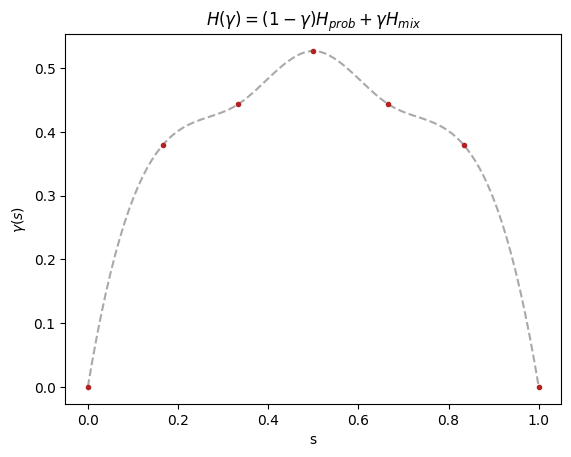

In [13]:
loss_opt = loss_ra(x1_opt, x2_opt, x3_opt)
print('Optimized spectral gap = ', -loss_opt.round(4))

schedule_opt = get_symmetric_schedule([x1_opt, x2_opt, x3_opt])
plot_schedule(schedule_opt, get_schedule_interpolator(schedule_opt, 'cubic')) 

In [14]:
ra_exp = {'n': n,
          'T': T,
          'interpolator_kind': interpolator_kind,
          't_max': t_max,
          'schedule_opt': schedule_opt.tolist(),
          'loss_opt': loss_opt,
          'first_optimizer': 'BO',
          'second_optimizer': 'None',
          'n_random_models': n_random_models,
          'n_iter': n_iter,
          'init_points': init_points,
          'kappa': kappa
          }

save_in_json(ra_exp, f'bo_cluster/{file_name}.json')